# CFG Tester Code

### Required Libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

### Create a directed graph

In [2]:
graph = nx.DiGraph()
graph.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6)])

start_node = 1
end_node = 6

### Plot graph

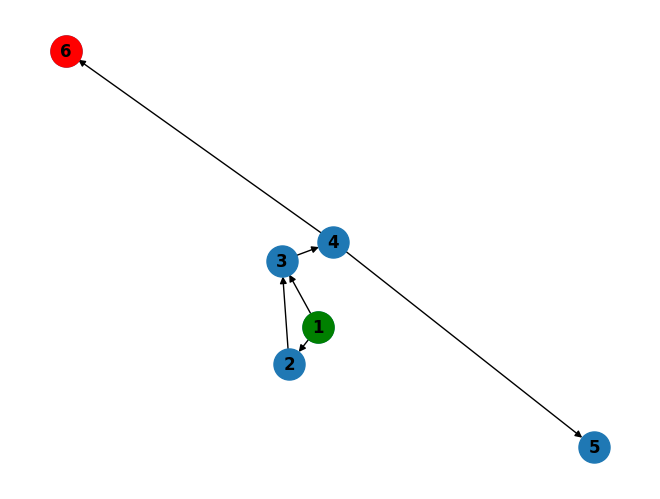

In [3]:
pos = nx.spring_layout(graph)  # Positions of the nodes
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=12, font_weight='bold')

# Draw start and end nodes with different colors
nx.draw_networkx_nodes(graph, pos, nodelist=[start_node], node_color='green', node_size=500)
nx.draw_networkx_nodes(graph, pos, nodelist=[end_node], node_color='red', node_size=500)

plt.show()

### Extract Prime Paths

In [7]:
def get_prime_paths(graph, start_node, end_node):
    # Step 1: Generate all simple paths
    all_paths = nx.all_simple_paths(graph, start_node, end_node)

    prime_paths = []  # List to store prime paths

    # Step 2: Remove redundant paths
    for path in all_paths:
        is_redundant = False
        for prime_path in prime_paths:
            if set(path).issubset(set(prime_path)):
                is_redundant = True
                break
        if not is_redundant:
            prime_paths.append(path)

    return prime_paths

prime_paths = get_prime_paths(graph, start_node, end_node)

In [8]:
print(prime_paths)

[[1, 2, 3, 4, 6]]
